In [1]:
import glob
import csv
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip install funcy
import funcy
from funcy import print_durations
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from torch.cuda.amp import GradScaler
torch.backends.cudnn.benchmark = True
import datetime
import gc
import pickle
from torchsummary import summary

/opt/conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Defaulting to user installation because normal site-packages is not writeable


In [2]:
start_date = '1980-01-01'

In [3]:
returns_df = pd.read_csv('returns.csv',index_col=0).loc[start_date:]
# returns_df = returns_df.dropna(axis=0,thresh=500).dropna(axis=1,thresh=500)
equity_idx = returns_df.columns
date_idx = returns_df.index
returns_df = returns_df.clip(returns_df.quantile(0.01,axis=1),returns_df.quantile(0.99,axis=1),axis=0)
returns_df

,0081A,0091A,0099A,0127A,0138A,0146A,0153A,0183B,0223B,0230B,...,ZVXI,ZWRK,ZWS,ZXAIY,ZY,ZYME,ZYNE,ZYXI,ZZ,ZZ1
datadate,,,,,,,,,,,,,,,,,,,,,
1980-01-31,NaN,0.012579,NaN,0.068182,0.039548,NaN,NaN,NaN,0.007752,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.137500
1980-02-29,NaN,-0.006211,NaN,0.000000,NaN,NaN,NaN,NaN,-0.086462,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.164835
1980-03-31,NaN,-0.306250,NaN,0.007092,NaN,NaN,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.118421
1980-04-30,NaN,0.252252,NaN,-0.126761,NaN,NaN,NaN,NaN,0.139130,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.029851
1980-05-31,NaN,0.071942,NaN,0.177419,NaN,NaN,NaN,NaN,0.036336,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.123077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001025,-0.033076,0.001111,-0.145283,-0.096180,-0.096606,0.021548,NaN,NaN
2021-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.001026,0.038516,0.054384,-0.261589,-0.184983,-0.167630,-0.221094,NaN,NaN
2022-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.004620,-0.160989,0.084211,-0.222720,-0.456986,-0.093750,-0.115145,NaN,NaN


In [4]:
feat_comb_df = pd.read_csv('features_full_final.csv').set_index(['tic','rdq']).drop(['FYEARQ','FQTR'],axis=1)
feat_comb_df = feat_comb_df[sorted(feat_comb_df.columns)]
feat_comb_df

A2ME        AC        AT       ATO      BEME      BETA  \
tic   rdq                                                                      
0081A 1996-12-31       NaN       NaN       NaN       NaN       NaN       NaN   
      1997-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
      1997-02-28  0.564765       NaN   140.274       NaN       NaN       NaN   
      1997-03-31  0.564765       NaN   140.274       NaN       NaN       NaN   
      1997-04-30  0.529462       NaN   146.767       NaN       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
ZZ    2012-10-31  5.840417  0.377852   971.509  0.888069 -0.316438  0.503049   
      2012-11-30  5.840417  0.377852   971.509  0.888069 -0.316438  0.503035   
      2012-12-31  5.840417  0.377852   971.509  0.888069 -0.316438  0.500307   
      2013-01-31  4.440987  0.489857  1005.345  1.081163 -0.253677  0.501021   
      2013-02-28  4.440987  0.489857  1005.345  1.081163 -0.253677  0.500922   

                         C  CF      CF2P       CTO  ...  REL2HIGH  RESID_VAR  \
tic   rdq                                           ...                        
0081A 1996-12-31       NaN NaN       NaN       NaN  ...       NaN        NaN   
      1997-01-31       NaN NaN       NaN       NaN  ...       NaN        NaN   
      1997-02-28  0.011328 NaN       NaN       NaN  ...       NaN   1.896184   
      1997-03-31  0.011328 NaN       NaN       NaN  ...       NaN   2.542292   
      1997-04-30  0.014431 NaN       NaN       NaN  ...       NaN   2.653953   
...                    ...  ..       ...       ...  ...       ...        ...   
ZZ    2012-10-31  0.091438 NaN -0.015174  0.549053  ...  0.910204   1.851362   
      2012-11-30  0.091438 NaN -0.015174  0.549053  ...  0.885714   0.619041   
      2012-12-31  0.091438 NaN -0.015174  0.549053  ...  0.885714   0.598993   
      2013-01-31  0.127473 NaN  0.042809  0.614895  ...  0.881633   0.542592   
      2013-02-28  0.127473 NaN  0.042809  0.614895  ...  0.889796   0.429795   

                       RNA       ROA       ROE       S2P     SGA2S   ST_REV  \
tic   rdq                                                                     
0081A 1996-12-31       NaN       NaN       NaN       NaN       NaN      NaN   
      1997-01-31       NaN       NaN       NaN       NaN       NaN      NaN   
      1997-02-28       NaN       NaN       NaN       NaN       NaN   1.5583   
      1997-03-31       NaN       NaN       NaN       NaN       NaN  10.7738   
      1997-04-30       NaN       NaN       NaN       NaN       NaN  -2.7778   
...                    ...       ...       ...       ...       ...      ...   
ZZ    2012-10-31  0.118627 -0.009920  0.167075  7.568810  0.818410  36.2500   
      2012-11-30  0.118627 -0.009920  0.167075  7.568810  0.818410   2.2936   
      2012-12-31  0.118627 -0.009920  0.167075  7.568810  0.818410  -2.6906   
      2013-01-31  0.167337  0.002145 -0.024645  5.954049  0.798554   0.0000   
      2013-02-28  0.167337  0.002145 -0.024645  5.954049  0.798554  -0.4608   

                       SUV  VARIANCE  
tic   rdq                             
0081A 1996-12-31       NaN       NaN  
      1997-01-31       NaN       NaN  
      1997-02-28       NaN  4.225542  
      1997-03-31       NaN  6.975184  
      1997-04-30       NaN  7.456677  
...                    ...       ...  
ZZ    2012-10-31  0.669890  4.256721  
      2012-11-30 -0.125130  0.458271  
      2012-12-31  0.062727  0.420686  
      2013-01-31 -1.501970  0.311550  
      2013-02-28 -0.227316  0.230933  

[3692558 rows x 45 columns]

In [5]:
MIN_AVAILABLE_FEATURES = feat_comb_df.shape[1]//2

full_df_lst = []
for date in tqdm(date_idx):
    sub = feat_comb_df.loc[feat_comb_df.index.get_level_values(1) <= date]
    sub = sub.groupby(sub.index.get_level_values('tic')).last(1)
    sub = sub.transpose()
    
    sub = sub.rank(pct=True,axis=1)*2-1
    idx = (sub.isna().sum(axis=0) >= MIN_AVAILABLE_FEATURES).index
    sub = sub[idx].fillna(0)
    
#     sub = sub.fillna(sub.median(axis=1),axis=0)
    
    sub['date'] = date
    sub =  sub.set_index(['date',sub.index])
    
    full_df_lst.append(sub)

del feat_comb_df
gc.collect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 507/507 [09:21<00:00,  1.11s/it]


0

# Train Test Split

In [6]:
class AEDataSet(torch.utils.data.Dataset):
    def __init__(self, full_df_lst, returns_df, date_idx, start_i, end_i, rhs_input_assets=False,lag=1):
        self.full_df_lst = full_df_lst
        self.returns_df = returns_df
        self.date_idx = date_idx
        self.start_i, self.end_i = start_i, end_i
        self.rhs_input_assets = rhs_input_assets
        self.epsilon=1e-5
        self.lag=lag
        
        self.output_date_idx = date_idx[start_i+lag:end_i]
        
    def __len__(self):
        return self.end_i - self.start_i - self.lag
    def __getitem__(self, idx):
        input_idx = idx
        idx += self.start_i+self.lag
        date = self.date_idx[idx] # returns date
        
        mask = ~np.isnan(self.returns_df.loc[date].to_numpy())
        traded_assets_idx = self.returns_df.columns[mask]
        
        lhs = self.full_df_lst[idx - self.lag]
        lhs_idx = lhs.columns
        
        comb_idx = traded_assets_idx.intersection(lhs_idx)
        
        lhs = lhs.reindex(comb_idx,axis=1,fill_value=0).to_numpy()
        
        rhs_tmp = self.returns_df.loc[date,comb_idx]
        rhs_tmp = rhs_tmp.clip(rhs_tmp.quantile(0.01),rhs_tmp.quantile(0.99))
        output = rhs_tmp.to_numpy()

        lhs_tmp = np.concatenate([lhs,np.expand_dims(np.ones(lhs.shape[1]),0)],axis=0)
        
        
        if self.rhs_input_assets:
            rhs = output
        else:
            try:
                rhs = (np.linalg.inv(lhs_tmp @ lhs_tmp.T) @ lhs_tmp) @ rhs_tmp
            except Exception as e:
                print("idx:",input_idx)
                print(e)
                raise e
        return lhs,rhs,output,comb_idx
        
        
def collate_fn(batch):

    len_x = [len(output) for lhs,rhs,output,_ in batch]
    full_size = max(len_x)
    
    batch_lhs = [nn.functional.pad(torch.Tensor(lhs),pad=(0,full_size-lhs.shape[1],0,0)) for lhs,rhs,output,_ in batch]
    batch_rhs = [torch.Tensor(rhs) for lhs,rhs,output,_ in batch]
    batch_output = [nn.functional.pad(torch.Tensor(output),pad=(0,full_size-len(output))) for lhs,rhs,output,_ in batch]
    batch_assets = [idx for lhs,rhs,output,idx in batch]
    
    return torch.cat([x.unsqueeze(0) for x in batch_lhs]),\
        torch.cat([x.unsqueeze(0) for x in batch_rhs]),\
        torch.cat([x.unsqueeze(0) for x in batch_output]), torch.tensor(len_x), batch_assets

# Conditional Autoencoder

In [7]:
class ConditionalAutoEncoder(nn.Module):
    def __init__(self, n_alphas, n_factors, n_hidden_lhs, n_hidden_rhs, 
                    batch_norm_lhs=True, batch_norm_rhs=False,
                    dropout_p=0, initialization=True, rhs_input_assets = False, rhs_activation = True,
                    bn_momentum=0.1, bn_track_running_stats = True):
        # n_assets can be assets or portfolios:
            # In both cases, we are interested in asset return or portfolio return on the RHS
            # LHS is the original factor 
        super(ConditionalAutoEncoder, self).__init__()

        self.n_alphas = n_alphas
        self.n_factors = n_factors
        self.n_hidden_lhs = list(n_hidden_lhs)
        self.n_hidden_rhs = list(n_hidden_rhs)

        self.lhs_lst = []

        prev_lhs_layer_size = self.n_alphas
        layer_lst = []
        for i, v in enumerate(list(n_hidden_lhs)+[n_factors]):
            if batch_norm_lhs and i<len(n_hidden_lhs):
                # layer_lst.append(nn.BatchNorm1d(prev_lhs_layer_size,momentum=bn_momentum,
                #         track_running_stats=bn_track_running_stats))
                layer_lst.append(nn.LayerNorm(prev_lhs_layer_size))
            if dropout_p:
                layer_lst.append(nn.Dropout(dropout_p))
            layer_lst.append(nn.Linear(prev_lhs_layer_size, v, bias=True))
            if initialization:
                nn.init.kaiming_normal_(layer_lst[-1].weight,mode='fan_in',nonlinearity='linear')
            if i<len(n_hidden_lhs):
                layer_lst.append(nn.SELU())
            prev_lhs_layer_size = v
#         layer_lst = layer_lst[:-1]
        # if batch_norm_lhs:
        #     layer_lst.append(nn.BatchNorm1d(prev_lhs_layer_size,momentum=bn_momentum,
        #             track_running_stats=bn_track_running_stats))
        #     # layer_lst.append(nn.LayerNorm(prev_lhs_layer_size))
        # if dropout_p:
        #     layer_lst.append(nn.Dropout(dropout_p))
        # layer_lst.append(nn.Linear(prev_lhs_layer_size, self.n_factors, bias=True))
        # if initialization:
        #     nn.init.xavier_normal_(layer_lst[-1].weight)
        self.lhs = nn.Sequential(*layer_lst)

        # self.lhs_lst = nn.ModuleList(self.lhs_lst)

        rhs_lst = []
#         if rhs_input_assets:
#             if batch_norm_rhs:
#                 # rhs_lst.append(nn.BatchNorm1d(self.n_assets,momentum=bn_momentum,
#                 #     track_running_stats=bn_track_running_stats))
#                 rhs_lst.append(nn.LayerNorm(self.n_assets))
#             if dropout_p:
#                 rhs_lst.append(nn.Dropout(dropout_p))
#             rhs_lst.append(nn.Linear(n_assets,n_alphas+1,bias=True))
#             if initialization:
#                 nn.init.kaiming_normal_(rhs_lst[-1].weight,mode='fan_in',nonlinearity='linear')
#             if rhs_activation:
#                 rhs_lst.append(nn.SELU())

        prev_rhs_layer_size = self.n_alphas+1
        for v in n_hidden_rhs+[n_factors]:
            if batch_norm_rhs:
              # rhs_lst.append(nn.BatchNorm1d(prev_rhs_layer_size,momentum=bn_momentum,
              #         track_running_stats=bn_track_running_stats))
                rhs_lst.append(nn.LayerNorm(prev_rhs_layer_size))
            if dropout_p:
                rhs_lst.append(nn.Dropout(dropout_p))
            rhs_lst.append(nn.Linear(prev_rhs_layer_size,v,bias=True))
            if initialization:
                nn.init.kaiming_normal_(rhs_lst[-1].weight,mode='fan_in',nonlinearity='linear')
            if rhs_activation:
                rhs_lst.append(nn.SELU())
            prev_rhs_layer_size = v
        
        self.rhs = nn.Sequential(*rhs_lst)

#         self.final = nn.Linear(n_assets,n_assets,bias=True)

    def forward(self, x_lhs, x_rhs):
        # idx = 0
        y_lhs_lst = []
        for i in range(x_lhs.shape[2]):
            # y_cur = self.lhs_lst[i](x_lhs[:,idx:idx+self.n_alphas])
            y_cur = self.lhs(x_lhs[:,:,i])
            y_cur = torch.unsqueeze(y_cur,2)
            y_lhs_lst.append(y_cur)
            # idx += self.n_alphas
        y_lhs = torch.cat(y_lhs_lst,dim=2)

        y_rhs = self.rhs(x_rhs).unsqueeze(dim=2)
        self.last_rhs_factors = y_rhs
        out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
#         out = self.final(out)
        return out, y_rhs

    def forward_given_factors(self, x_lhs, factors):
        y_lhs_lst = []
        for i in range(x_lhs.shape[2]):
            # y_cur = self.lhs_lst[i](x_lhs[:,idx:idx+self.n_alphas])
            y_cur = self.lhs(x_lhs[:,:,i])
            y_cur = torch.unsqueeze(y_cur,2)
            y_lhs_lst.append(y_cur)
            # idx += self.n_alphas
        y_lhs = torch.cat(y_lhs_lst,dim=2)

        y_rhs = factors
        out = torch.bmm(y_lhs.transpose(1,2), y_rhs).squeeze(2)
#         out = self.final(out)
        return out

In [8]:
checkpoint_lst = [
    'efs/project/final_baseline_multirun_layers12_hidden_24_12_noactivation_run_1.checkpoint',
    'efs/project/final_baseline_multirun_layers12_hidden_24_12_noactivation_run_2.checkpoint',
    'efs/project/final_baseline_multirun_layers12_hidden_24_12_noactivation_run_3.checkpoint',
    'efs/project/final_baseline_multirun_layers12_hidden_24_12_noactivation_run_4.checkpoint',
    'efs/project/final_baseline_multirun_layers12_hidden_24_12_noactivation_run_5.checkpoint',
    'efs/project/final_baseline_multirun_layers12_hidden_24_12_noactivation_run_6.checkpoint',
    'efs/project/final_baseline_multirun_layers12_hidden_24_12_noactivation_run_7.checkpoint',
#     'efs/project/final_baseline_multirun_layers12_hidden_24_12_noactivation_run_8.checkpoint',
#     'efs/project/final_baseline_multirun_layers12_hidden_24_12_noactivation_run_9.checkpoint',
#     'efs/project/final_baseline_multirun_layers12_hidden_24_12_noactivation_run_10.checkpoint',
]


with open('res_dict_final_baseline_k12_multirun.pickle', 'rb') as handle:
    res_dict = pickle.load(handle)
print(list(res_dict.keys())[0])
res_dict_lst = list(res_dict.values())
for i in range(len(res_dict_lst)):
    checkpoint = torch.load(checkpoint_lst[i])
    res_dict_lst[i]['model_state_dict'] = checkpoint['model_state_dict']

total_corr_lst = []
for i,rd in enumerate(res_dict_lst):
    total_corr_lst.append((i,rd['total_spearman_corr']))
total_corr_lst.sort(key=lambda t: t[1],reverse=True)
print(total_corr_lst[:5])
chosen_res_dict_lst = [res_dict_lst[t[0]] for t in total_corr_lst[:5]]

(12, (24, 12), 1, False)
[(0, 0.06566753592581719), (3, 0.06370256684712648), (6, 0.05943424677623239), (4, 0.05237814441360525), (5, 0.01764309039253912)]


In [9]:
# checkpoint_lst = [
# #     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_1.checkpoint',
# #     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_2.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_3.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_4.checkpoint',
# #     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_5.checkpoint',
# #     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_6.checkpoint',
# #     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_7.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_8.checkpoint',
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_9.checkpoint',    
#     'final_baseline_multirun_layers4_hidden_24_12_noactivation_run_10.checkpoint',
# ]

model_lst = []

# torch.load('midterm_corrected_layers6_hidden_16_8_noactivation.checkpoint')

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

args = fixed_args = {
    'n_factors' : 12,
    'n_hidden_lhs':[24,12],
    'n_hidden_rhs':[],
    'batch_norm_lhs' : True,
    'batch_norm_rhs' : False,
    'rhs_activation': False,
    'dropout_p' : 0.0,
    'max_norm' : 1,
    'bn_momentum': 0.01,
    'bn_track_running_stats': True,
    'initialization' : False,
    'rhs_input_assets' : False,
    'lr' : 5e-4,
    'gamma': 1/4,
    'l2_lambda': 0,
    'l1_lambda': 4e-3,
    'batch_size': 32,
    'log_interval': 1,
    'epoch': 60,
    'patience': 6
}

n_alphas = 45
batch_size=16
n_window=36
test_start, test_end = 420,505

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_data = AEDataSet(full_df_lst,returns_df,date_idx,test_start,test_end)
extended_test_data = AEDataSet(full_df_lst,returns_df,date_idx,test_start-n_window,test_end)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size = batch_size,
    pin_memory=True,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_fn
)

extended_test_loader = torch.utils.data.DataLoader(
    extended_test_data,
    batch_size = batch_size,
    pin_memory=True,
    num_workers=0,
    shuffle=False,
    collate_fn = collate_fn
)


In [10]:
predicted_returns_lst = []
predicted_factors_lst = []
output_df_lst = []
factors_df_lst = []

for rd in chosen_res_dict_lst:
    
#     checkpoint = torch.load(name)

    model = ConditionalAutoEncoder(
        n_alphas = n_alphas,
        n_factors = args['n_factors'],
        n_hidden_lhs = args['n_hidden_lhs'],
        n_hidden_rhs = args['n_hidden_rhs'],
        batch_norm_lhs = args['batch_norm_lhs'],
        batch_norm_rhs = args['batch_norm_rhs'],
        dropout_p=args['dropout_p'],
        initialization=args['initialization'],
        rhs_input_assets=args['rhs_input_assets'],
        rhs_activation = args['rhs_activation']
    #     bn_track_running_stats=args['bn_track_running_stats'],
    #     bn_momentum=args['bn_momentum']
    )

    model.load_state_dict(rd['model_state_dict'])
    model.to(device)
    model_lst.append(model)
    
    gc.collect()
    torch.cuda.empty_cache()
    
    output_lst = []
    data_lst = []
    factors_lst = []

    for data_lhs, data_rhs, data_output, data_x_lens, data_assets in tqdm(extended_test_loader):
        # print("Shapes:",data_lhs.shape, data_rhs.shape, data_output.shape, data_mask.shape)
        data_lhs = data_lhs.float().to(device)
        data_rhs = data_rhs.float().to(device)
        data_output = data_output.float().to(device)
        data_x_lens = data_x_lens.int().to(device)
        output, factors = model(x_lhs = data_lhs, x_rhs = data_rhs)

        data_mask = torch.arange(data_lhs.shape[2])[None, :].to(device) < data_x_lens[:, None]
        output_masked = torch.masked_select(output,data_mask)
        data_output_masked = torch.masked_select(data_output,data_mask)
        assert (len(output_masked) == torch.sum(data_x_lens))

        indices = [0]+list(torch.cumsum(data_x_lens,axis=0).cpu().numpy())

        for k,(i,j) in enumerate(zip(indices[:-1],indices[1:])):
            output_lst.append(pd.Series(output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
            data_lst.append(pd.Series(data_output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
            factors_lst.append(pd.Series(factors[k].squeeze().cpu().detach().numpy()))

    gc.collect()
    torch.cuda.empty_cache()

    output_df = pd.DataFrame(output_lst,index=extended_test_data.output_date_idx).iloc[n_window:]
    data_output_df = pd.DataFrame(data_lst,index=extended_test_data.output_date_idx).iloc[n_window:]
    factors_df = pd.DataFrame(factors_lst,index=extended_test_data.output_date_idx)

    predicted_factors = factors_df.rolling(n_window).mean()
    factors_tensor = torch.tensor(predicted_factors.iloc[n_window:].to_numpy()).unsqueeze(2).float().to(device)


    pred_output_lst = []
    for i, (data_lhs, _, _, data_x_lens, data_assets) in tqdm(enumerate(test_loader),total=len(test_loader)):
        data_lhs = data_lhs.float().to(device)
        data_x_lens = data_x_lens.int().to(device)
        output= model.forward_given_factors(x_lhs = data_lhs, factors = factors_tensor[i*batch_size:(i+1)*batch_size])

        data_mask = torch.arange(data_lhs.shape[2])[None, :].to(device) < data_x_lens[:, None]
        output_masked = torch.masked_select(output,data_mask)
        assert (len(output_masked) == torch.sum(data_x_lens))

        indices = [0]+list(torch.cumsum(data_x_lens,axis=0).cpu().numpy())

        for k,(i,j) in enumerate(zip(indices[:-1],indices[1:])):
            pred_output_lst.append(pd.Series(output_masked[i:j].cpu().detach().numpy(),index=data_assets[k]))
    tm1_predicted_returns = pd.DataFrame(pred_output_lst,index=predicted_factors.iloc[n_window:].index)
    predicted_returns = tm1_predicted_returns.shift(1).iloc[1:]
    
    predicted_returns_lst.append(predicted_returns)
    predicted_factors_lst.append(predicted_factors)
    factors_df_lst.append(factors_df)
    output_df_lst.append(output_df)

    gc.collect()
    torch.cuda.empty_cache()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.20s/it]


In [11]:
data_dict = {
    'predicted_returns_lst': predicted_returns_lst,
    'predicted_factors_lst': predicted_factors_lst,
    'output_df_lst': output_df_lst,
    'factors_df_lst': factors_df_lst,
#     'y_macro_df_lst': y_macro_df_lst
}

with open('vanilla12.data', 'wb') as handle:
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# predicted_returns = predicted_returns_lst[1]
# for df in predicted_returns_lst[1:6]:
#     predicted_returns += df
predicted_returns = predicted_returns_lst[0]
for df in predicted_returns_lst[1:]:
    predicted_returns += df
predicted_returns /= len(predicted_returns_lst)

output_df = output_df_lst[0]
for df in output_df_lst[1:]:
    output_df += df
output_df /= len(output_df_lst)

log_dict = {}


# Predictive Stats:
# Spearman Corr
corr = predicted_returns.corrwith(returns_df.loc[predicted_returns.index,predicted_returns.columns],axis=1,method='spearman')
log_dict['pred_spearman_corr'] = corr.mean()
# R2
numer = (returns_df.loc[predicted_returns.index,predicted_returns.columns]-predicted_returns)
numer_mask = (~numer.isna()).astype(int)
denom = returns_df.loc[predicted_returns.index,predicted_returns.columns] * numer_mask
log_dict['pred_r2'] = (1 - ((numer**2).sum(axis=1))/(denom**2).sum(axis=1)).mean()

# Attribution Stats:
# Spearman Corr
corr = output_df.corrwith(returns_df.loc[output_df.index,output_df.columns],axis=1,method='spearman')
log_dict['total_spearman_corr'] = corr.mean()
# R2
numer = (returns_df.loc[output_df.index,output_df.columns]-output_df)
numer_mask = (~numer.isna()).astype(int)
denom = returns_df.loc[output_df.index,output_df.columns] * numer_mask
log_dict['total_r2'] = (1 - ((numer**2).sum(axis=1))/(denom**2).sum(axis=1)).mean()

# Trading Stats:
train_pred_rank = predicted_returns.rank(pct=True,axis=1,numeric_only=True,ascending=True)
long_port = ((train_pred_rank >= 0.9) & (train_pred_rank < 1)).astype(int)
long_port = long_port.divide(long_port.sum(axis=1),axis=0)
long_port_returns = (long_port*returns_df.loc[long_port.index]).sum(axis=1)
short_port = (train_pred_rank <= 0.1).astype(int)
short_port = short_port.divide(short_port.sum(axis=1),axis=0)
short_port_returns = (short_port*returns_df.loc[short_port.index]).sum(axis=1)
comb_port = long_port - short_port
comb_port_returns = (comb_port*returns_df.loc[comb_port.index]).sum(axis=1)
log_dict['long_short_SR'] = (comb_port_returns.mean()/comb_port_returns.std())*np.sqrt(12)
log_dict['long_short_returns'] = comb_port_returns.mean()*12
log_dict['long_short_SD'] = comb_port_returns.std()*np.sqrt(12)

log_dict['long_SR'] = (long_port_returns.mean()/long_port_returns.std())*np.sqrt(12)
log_dict['long_returns'] = long_port_returns.mean()*12
log_dict['long_SD'] = long_port_returns.std()*np.sqrt(12)

log_dict['short_SR'] = (short_port_returns.mean()/short_port_returns.std())*np.sqrt(12)
log_dict['short_returns'] = short_port_returns.mean()*12
log_dict['short_SD'] = short_port_returns.std()*np.sqrt(12)


In [13]:
log_dict

{'pred_spearman_corr': -0.016693345168847004,
 'pred_r2': -0.004784703537903496,
 'total_spearman_corr': 0.0837336018759579,
 'total_r2': 0.07593318897896609,
 'long_short_SR': -0.36380100037072366,
 'long_short_returns': -0.042263521686774594,
 'long_short_SD': 0.1161720876075295,
 'long_SR': 0.421965875487744,
 'long_returns': 0.07168102824448572,
 'long_SD': 0.16987399315556187,
 'short_SR': 0.577232994256463,
 'short_returns': 0.11394454993126027,
 'short_SD': 0.19739784638962446}

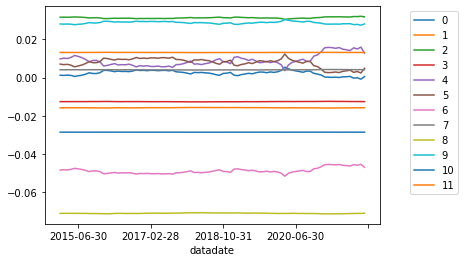

In [14]:
predicted_factors_lst[0].plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

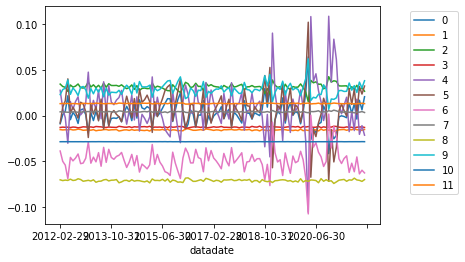

In [15]:
factors_df_lst[0].plot()
plt.legend(bbox_to_anchor=(1.25,1))
plt.show()

In [16]:
predicted_returns

,3PBCP,A,AA.3,AABA,AACG,AACH,AADR,AAIC,AAL,AAMC,...,WTAI,XBOC,XBTF,XDEC,XDOC,XLO,XPRO,XTOC,YUMY,ZGEN
datadate,,,,,,,,,,,,,,,,,,,,,
2015-03-31,0.010059,-0.001192,0.003236,-0.002759,0.004032,0.005020,0.006374,0.003289,0.007256,-0.001377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.011091,-0.001855,0.001617,-0.003446,0.005309,0.000058,0.003835,0.002600,0.005003,-0.001592,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,0.008755,-0.001410,0.002585,-0.003599,0.003756,-0.000499,0.002723,0.004151,0.003051,0.003305,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,0.009268,0.003422,0.004160,-0.001774,0.004710,0.002443,0.007015,0.003128,0.002118,0.004198,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,0.009716,0.001120,0.002979,-0.002008,0.006681,0.000068,0.005880,0.004356,0.001943,0.006996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,NaN,0.002076,NaN,NaN,0.011166,NaN,0.004952,0.015063,0.006731,0.001831,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31,NaN,0.001288,NaN,NaN,0.014527,NaN,0.003230,0.010400,0.004734,0.002048,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,NaN,0.001034,NaN,NaN,0.018190,NaN,0.004799,0.011872,0.006825,0.001203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
predicted_returns.rank(pct=True,axis=1,numeric_only=True,ascending=True)

,3PBCP,A,AA.3,AABA,AACG,AACH,AADR,AAIC,AAL,AAMC,...,WTAI,XBOC,XBTF,XDEC,XDOC,XLO,XPRO,XTOC,YUMY,ZGEN
datadate,,,,,,,,,,,,,,,,,,,,,
2015-03-31,0.952318,0.143339,0.508509,0.071596,0.586708,0.679137,0.777435,0.514231,0.838028,0.132629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,0.973279,0.117457,0.385112,0.055498,0.724270,0.249449,0.608134,0.479078,0.702687,0.131846,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,0.913600,0.127564,0.456145,0.040145,0.564945,0.190109,0.469236,0.599127,0.496582,0.521745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,0.898335,0.398627,0.480280,0.049226,0.536226,0.297984,0.763950,0.367368,0.267748,0.484663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-31,0.933070,0.240976,0.423937,0.059331,0.764577,0.162502,0.701447,0.564665,0.315651,0.786789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-30,NaN,0.128944,NaN,NaN,0.873176,NaN,0.347674,0.972565,0.543459,0.118344,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-10-31,NaN,0.109177,NaN,NaN,0.971328,NaN,0.234381,0.863653,0.388757,0.146363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-11-30,NaN,0.043526,NaN,NaN,0.992542,NaN,0.263480,0.874435,0.495660,0.047683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
predicted_returns.to_csv('Vanilla_predicted_returns.csv')
lstm_predicted_returns = pd.read_csv('LSTM_predicted_returns.csv',index_col=0)
lstm_predicted_returns_lowreg = pd.read_csv('LSTM_predicted_returns_lowreg.csv',index_col=0)

In [19]:
def get_sharpes_by_decile(train_pred_dict, metric='sharpe'):
    ranked_sharpes_dict = {}
    for name, train_pred in tqdm(train_pred_dict.items(),total=len(train_pred_dict)):
        train_pred_rank = train_pred.rank(pct=True,axis=1,numeric_only=True,ascending=True)

        ranks = np.arange(0,1,.1)
        ranked_returns = []

        for r in ranks:
            port = ((train_pred_rank >= r) & (train_pred_rank < r+.1)).astype(int)
            port = port.divide(port.sum(axis=1),axis=0)
            port_returns = (port*returns_df.loc[port.index]).sum(axis=1)
            ranked_returns.append(port_returns)
            
        ranked_df = pd.concat(ranked_returns,axis=1)
        ranked_df.columns = ranks
        if metric == 'sharpe':
            ranked_sharpe = ranked_df.mean() / ranked_df.std() * np.sqrt(12)
            ranked_sharpes_dict[name] = ranked_sharpe
        elif metric == 'returns':
            ranked_sharpes_dict[name] = ranked_df.mean() * 12
        elif metric == 'volatility':
            ranked_sharpes_dict[name] = ranked_df.std() * np.sqrt(12)

    return ranked_sharpes_dict

In [20]:
sharpes = get_sharpes_by_decile(
    {'Baseline':predicted_returns,
#      'LSTM CA': lstm_predicted_returns,
#      'LSTM CA lowreg': lstm_predicted_returns_lowreg
    },
    metric='sharpe'
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.36s/it]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Out of sample Sharpe Ratio (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Baseline,0.577,0.412,0.278,0.321,0.337,0.325,0.341,0.367,0.513,0.422


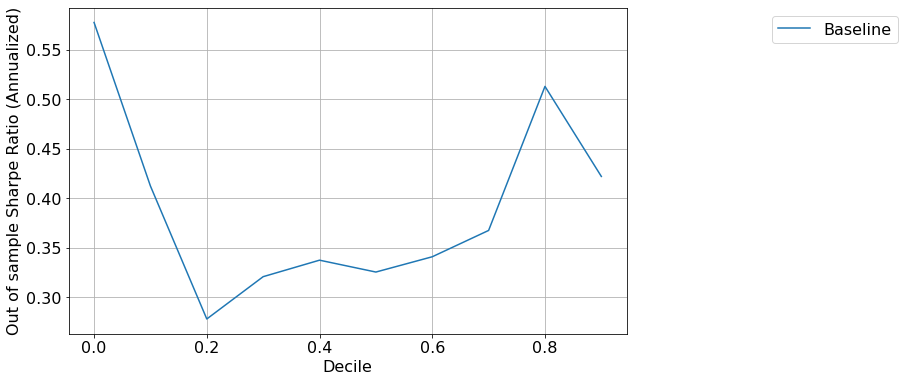

In [21]:
metric = 'sharpe'
ranked_sharpes_dict = get_sharpes_by_decile({'Baseline':predicted_returns,
#      'LSTM CA': lstm_predicted_returns,
#      'LSTM CA lowreg': lstm_predicted_returns_lowreg
                                            },metric=metric)
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.5,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Out of sample Returns (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Baseline,0.114,0.082,0.053,0.061,0.061,0.055,0.055,0.056,0.079,0.072


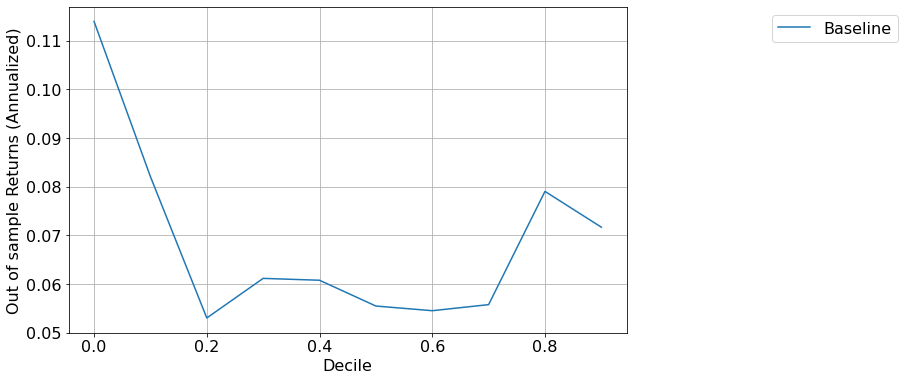

In [22]:
metric = 'returns'
ranked_sharpes_dict = get_sharpes_by_decile({'Baseline':predicted_returns,
#      'LSTM CA': lstm_predicted_returns,
#      'LSTM CA lowreg': lstm_predicted_returns_lowreg
                                            },metric=metric)
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.5,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.35s/it]

Out of sample Volatility (Annualized)


,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Baseline,0.197,0.199,0.191,0.191,0.18,0.17,0.16,0.152,0.154,0.17


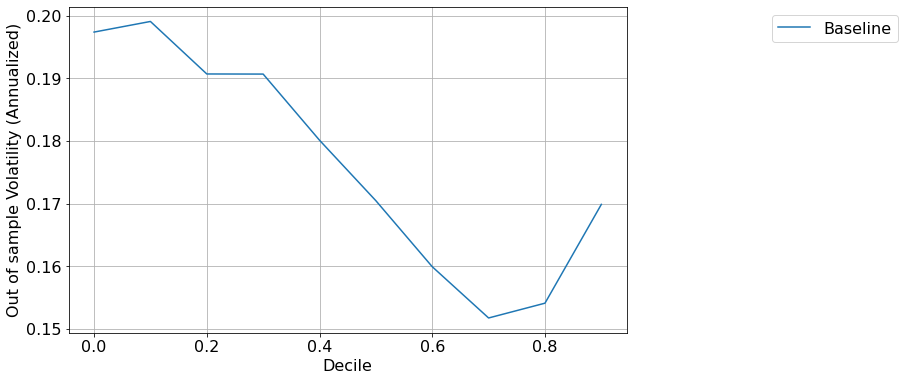

In [23]:
metric = 'volatility'
ranked_sharpes_dict = get_sharpes_by_decile({'Baseline':predicted_returns,
#      'LSTM CA': lstm_predicted_returns,
#      'LSTM CA lowreg': lstm_predicted_returns_lowreg
                                            },metric=metric)
metric = {
    "returns": "Returns",
    "volatility": "Volatility",
    "sharpe": "Sharpe Ratio"
}[metric]
title = f"Out of sample {metric} (Annualized)"
plt.rcParams.update({'font.size': 16,})

pred_sharpes_df = pd.DataFrame(ranked_sharpes_dict).sort_index(axis=1)#.drop(['true_returns'],axis=1)
ax = pred_sharpes_df.plot(figsize=(10,6))
plt.xlabel("Decile")
plt.ylabel(title)
ax.legend(bbox_to_anchor=(1.5,1))
plt.grid()
print(title)
pred_sharpes_df.transpose().round(3)

Annualized Return: 0.07168102824448572
Annualized SD: 0.16987399315556187
Annualized Sharpe: 0.421965875487744


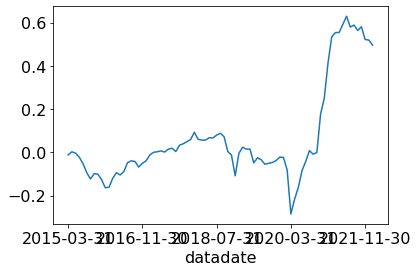

In [24]:
long_port = ((train_pred_rank >= 0.9) & (train_pred_rank < 1)).astype(int)
long_port = long_port.divide(long_port.sum(axis=1),axis=0)
long_port_returns = (long_port*returns_df.loc[long_port.index]).sum(axis=1)
long_port_returns.cumsum().plot()
print("Annualized Return:",long_port_returns.mean()*12)
print("Annualized SD:",long_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(long_port_returns.mean()/long_port_returns.std())*np.sqrt(12))

Annualized Return: 0.11394454993126027
Annualized SD: 0.19739784638962446
Annualized Sharpe: 0.577232994256463


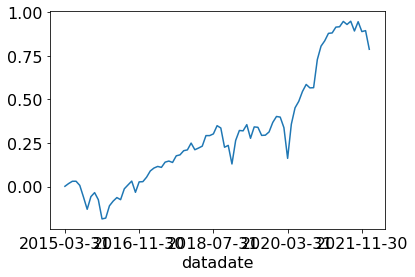

In [25]:
# train_pred_rank = train_pred.rank(pct=True,axis=1,numeric_only=True,ascending=False)
short_port = (train_pred_rank <= 0.1).astype(int)
short_port = short_port.divide(short_port.sum(axis=1),axis=0)
short_port_returns = (short_port*returns_df.loc[short_port.index]).sum(axis=1)
short_port_returns.cumsum().plot()
print("Annualized Return:",short_port_returns.mean()*12)
print("Annualized SD:",short_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(short_port_returns.mean()/short_port_returns.std())*np.sqrt(12))


Annualized Return: -0.042263521686774594
Annualized SD: 0.1161720876075295
Annualized Sharpe: -0.36380100037072366


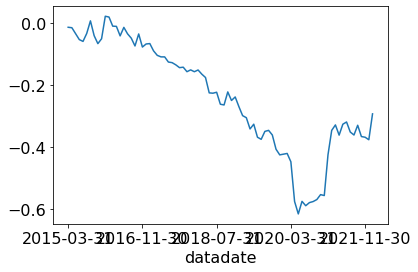

In [26]:
full_port = long_port - short_port
full_port_returns = (full_port*returns_df.loc[full_port.index]).sum(axis=1)
full_port_returns.cumsum().plot()
print("Annualized Return:",full_port_returns.mean()*12)
print("Annualized SD:",full_port_returns.std()*np.sqrt(12))
print("Annualized Sharpe:",(full_port_returns.mean()/full_port_returns.std())*np.sqrt(12))
